
# 1. Data Scrapping from Amazon
---

Code to web scrapping and generate csv file through pandas

Note: i have to run the script couple times with different search_query value setting, since i think there is some issue with the JupyterNotebook cache, which prevent me from fetching large size of data. In this case, i need to clean up the runtime and rerun the script to generate all the csv files

---



In [59]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from time import sleep
from pprint import pprint
import time
  
# Using python requests package to request data from amazon webpage

# setting up the header to the requests config
# this will let the amazon server consider the data is fetching through a web-browser not a scrapper
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.88 Safari/537.36',
    'Accept-Language': 'en-US, en;q=0.9'
}

# helper function to construct the searching url\
# url needs to be specified here, cuz i did not find a generic formula to bypass 7 results limit
def construct_url(search_query, page):
  return 'https://www.amazon.com/s?k={0}&i=pets&page={1}&sprefix={0}%2Cpets%2C84&ref=sr_pg_{1}'.format(search_query, page)



# helper function to parse the ASIN ( Amazon Standard Identification Number ) from the product url
# from inspection, there are two kinds of product url
# example #1: https://amazon.com/Purina-Friskies-Poultry-Adult-Variety/dp/B00283MYSI/ref=sr_1_5?keywords=Cat+Food&qid=1651808178&sr=8-5
#             for the first one i look for the location of /dp/, and read the following 10 char, since ASIN is 10 digits
# example #2: https://amazon.com/gp/slredirect/picassoRedirect.html/ref=pa_sp_atf_aps_sr_pg1_1?ie=UTF8&adId=A10381923N5472SMZ6UR&url=%2
#             FDry-Cat-Food-Turkey-Recipe%2Fdp%2FB07RX8N15B%2Fref%3Dsr_1_1_sspa%3Fkeywords%3DCat%2BFood%26qid%3D1651808178%26sr%3D8-1-spons%26psc%3D1&qualifier=1651808178&id=401474085727698&widgetName=sp_atf
#             for the second one, i look for the location of %2Fdp%2F, since %2F is the URL encoded value of '/', and then read the following 10 chars
# this is needed for the reference usage upon analysis the review
def extract_asin_from_url(url):
  # trying to find the index of the dp
  dp_index_1 = url.find('/dp/')
  dp_index_2 = url.find('%2Fdp%2F')

  # extract the ASIN from it
  if dp_index_1 != -1:
    # /dp/
    start_index = dp_index_1 + 4
    return url[start_index: start_index+10]
  elif dp_index_2 != -1:
    # %2Fdp%2F
    start_index = dp_index_2 + 8
    return url[start_index: start_index+10]
  else:
    return 'N/A'

# set search string
search_query = 'dog treats'.replace(' ', '+')
# base_url = 'https://www.amazon.com/s?k={0}'.format(search_query)

def scrap_amazon(search_query):
  # initiate the array to store the items we wanna fetch
  items = []

  # fetch the first 20 pages of items, so we loop for 20 times
  for i in range(1, 20):
    # construct the url
    cur_url = construct_url(search_query, i)

    # log the process
    print('Processing {0}...'.format(cur_url))

    # sending request to target url
    response = requests.get(cur_url, headers=headers)

    # construct the soup object using the beautifulSoup package
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # parsing all the div tag by class
    # from the chrome dev tool inspection, the class name shown following contains the main page of the search result of amazon search
    results = soup.find_all('div', {'class': 's-result-item', 'data-component-type': 's-search-result'})
    # loop through the soup result to construct the dataframe
    for result in results:
      product_name = result.h2.text

      try:
        # extract the rating value as it is under the i tag class a-icon
        rating = result.find('i', {'class': 'a-icon'}).text
        # some of the items do not have rating count, thus we throw IndexError below
        rating_count = result.find_all('span', {'aria-label': True})[1].text
      except AttributeError:
        continue
      except IndexError:
        continue

      try:
        # found all the prices info
        # sale price is contructed by two elements in the html, with class name a-price-whole and a-price-fraction
        price_whole = result.find('span', {'class': 'a-price-whole'}).text
        price_fraction = result.find('span', {'class': 'a-price-fraction'}).text
        price = float(price_whole + price_fraction)


        # extrac the unit price and get rid of the partheness around it
        unit_price = result.find('span', {'class': 'a-size-base a-color-secondary'}).text

        # extract the url of the product link, we will use it for the review analysis later
        product_url = 'https://amazon.com' + result.h2.a['href']

        # extract the ASIN number from the url
        product_asin = extract_asin_from_url(product_url)

        # ts stores the time in seconds
        time_stamp = time.time()

        # price = 0
        # unit_price = 0
        # product_url = 0
        # product_asin = 0
        
        # construct the item
        items.append([product_name, rating, rating_count, price, unit_price, product_asin, product_url, time_stamp])
      except AttributeError:
          continue

    # wait for 1.5 secs in case Amazon blocks me
    sleep(3)

  pprint(len(items))
  # pprint(items[:10])
  df = pd.DataFrame(items, columns=['product', 'rating', 'rating count', 'price', 'unit_price', 'product_asin', 'product_url', 'time_stamp'])
  df.to_csv('{0}.csv'.format(search_query), index=False)

# run the following function to start the scrapping
# comment out here
# scrap_amazon(search_query=search_query)


#2. Prepare the dataset
---
NOTE: the above code is not necessary to be ran again, as i have ran it to generate required data
Read the data from all the csv files generated above
I did the scrapping on 6 categories: 

1. cat+food
2. cat+treats
3. dog+food
4. dog+treats
5. fish+food
6. bird+food

cat+food and cat+treats will be comibined into single datafram, same as dog+food and dog+treats while there are not specific treats for fish and birds, so there we dont need to perform any modification on the datasets of birds and fish

---



In [60]:
# import necessary package
try:
    import pandas as pd
except ImportError:
    print('You have imported the {} module'.format('pandas'))

import numpy as np

try:
    from pprint import pprint
except ImportError:
    print('You have imported the {} module'.format('pprint'))


from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# read csv into dataframe

base_dataset_path = '/content/drive/MyDrive/IST 652 Lab/Final Project/dataset/'

# cat
cat_food_df = pd.read_csv('{0}cat+food.csv'.format(base_dataset_path), encoding = 'utf-8', on_bad_lines='skip')
# cat_treats_df = pd.read_csv('/content/drive/MyDrive/IST 652 Lab/Final Project/dataset/cat+treats.csv', encoding = 'utf-8', on_bad_lines='skip')
# cat_df = pd.concat([cat_food_df, cat_treats_df], ignore_index=True)
cat_df = cat_food_df.copy()

# dog
dog_food_df = pd.read_csv('{0}dog+food.csv'.format(base_dataset_path), encoding = 'utf-8', on_bad_lines='skip')
# dog_treats_df = pd.read_csv('/content/drive/MyDrive/IST 652 Lab/Final Project/dataset/dog+treats.csv', encoding = 'utf-8', on_bad_lines='skip')
# dog_df = pd.concat([dog_food_df, dog_treats_df], ignore_index=True)
dog_df = dog_food_df.copy()

# bird
bird_df = pd.read_csv('{0}bird+food.csv'.format(base_dataset_path), encoding = 'utf-8', on_bad_lines='skip')

# fish
fish_df = pd.read_csv('{0}fish+food.csv'.format(base_dataset_path), encoding = 'utf-8', on_bad_lines='skip')

display(cat_df.head(5))

,product,rating,rating count,price,unit_price,product_asin,product url
0,"Hill's Science Diet Dry Cat Food, Adult, Chick...",4.8 out of 5 stars,"8,966",19.03,($4.76/lb),B000084DWM,https://amazon.com/gp/slredirect/picassoRedire...
1,Blue Buffalo Sensitive Stomach Natural Adult D...,4.8 out of 5 stars,"5,783",39.98,($2.67/lb),B008EXERJK,https://amazon.com/gp/slredirect/picassoRedire...
2,"Purina Beyond Grain Free, Natural, Chicken Adu...",4.7 out of 5 stars,"4,533",45.99,($2.87/lb),B07DWJYPRV,https://amazon.com/gp/slredirect/picassoRedire...
3,Meow Mix Original Choice Dry Cat Food,4.8 out of 5 stars,"24,585",19.12,($1.52/lb),B078229TVR,https://amazon.com/Meow-Mix-Original-Food-3-15...
4,Purina Friskies Canned Wet Cat Food 32 Count V...,4.7 out of 5 stars,"22,843",20.78,($1.89/lb),B00283MYSI,https://amazon.com/Purina-Friskies-Poultry-Adu...


In [62]:
# remove the partheness from the unit_pirce column, and divide the unit price column into two column, unit_price and unit
def process_unit_price(df):
  df_new = df.copy()
  #  get the unit_price list
  unit_price_list = df_new['unit_price'].tolist()
  
  # remove partheness
  unit_price_list = [up.replace('(','').replace(')','') for up in unit_price_list]

  # construct the unit list
  unit_list = [up[up.find('/')+1:] for up in unit_price_list]

  # remove dollar sign
  unit_price_list = [up[:up.find('/')].replace('$', '') for up in unit_price_list]

  df_new = df_new.assign(unit_price=unit_price_list)
  df_new = df_new.assign(unit=unit_list)
  df_new['currency'] = 'usd'
  return df_new

In [63]:
def my_to_numeric(x):
  try:
      return pd.to_numeric(x)
  except:
      return 0
      
# since amazon is using 5 star based rating system, we can literally keep the star only
# remove the out of xxx stuff from the rating column
def process_rating(df):
  df_new = df.copy()
  # replace nan by 'N/A'
  df_new['rating'].fillna(0, inplace=True)

  # convert to list
  rating_list = df_new['rating'].tolist()

  # remove the 'out of' string
  rating_list = [rating[:rating.find('out of')] if rating !=0 else rating for rating in rating_list]
  df_new = df_new.assign(rating=rating_list)

  # convert to float type
  df_new['rating'] = df_new['rating'].apply(my_to_numeric).astype('float')
  return df_new

In [64]:
# set the rating count, price, unit_price to float
def set_datatype(df):
  df_new = df.copy()
  df_new = df_new.rename(columns={'rating count': 'rating_count'})
  df_new = df_new.rename(columns={'product url': 'product_url'})
  # df_new['rating_count'] = df_new['rating_count'].astype('float')
  # df_new['unit_price'] = df_new['unit_price'].astype('float')
  
  # replace all nan with 0 here
  # df_new['rating_count'].fillna(0, inplace=True)
  df_new['rating_count'] = df_new['rating_count'].apply(lambda x: x.replace(',', ''))
  df_new['rating_count'] = df_new['rating_count'].apply(my_to_numeric)

  # df_new['rating_count'] = df_new['rating_count'].astype('float')
  # df_new['price'].fillna(0, inplace=True)
  # df_new['unit_price'].fillna(0, inplace=True)
  # df_new['unit_price'] = df_new['unit_price'].apply(lambda x: x.replace(',', ''))
  df_new['unit_price'] = df_new['unit_price'].apply(my_to_numeric)
  df_new['unit_price'] = df_new['unit_price'].astype('float')

  # df_new['rating'] = df_new.astype({'rating': 'float', 'rating_count': 'float', 'price': 'float', 'unit_price': 'float'})
  # df_new[['rating_count', 'price', 'unit_price']] = df_new[['rating_count', 'price', 'unit_price']].apply(my_to_numeric)
  return df_new

# remove duplicated on product_asin and set that as index
def remove_duplicate_and_indexing(df):
  df_new = df.copy()
  df_new = df.drop_duplicates(subset=['product_asin'])
  df_new = df_new.set_index('product_asin')
  return df_new

In [65]:
# covert string in product name to lower
def process_product_name(df):
  df_new = df.copy()
  df_new['product'] = df_new['product'].str.lower()
  return df_new

In [66]:
# run the two function upon each dataframe
def prepare_df(df):
  df_new = df.copy()
  df_new = process_unit_price(df_new)
  df_new = process_rating(df_new)
  df_new = set_datatype(df_new)
  df_new = remove_duplicate_and_indexing(df_new)
  # df_new = process_product_name(df_new)
  return df_new

cat_rdy_df = prepare_df(cat_df)
dog_rdy_df = prepare_df(dog_df)
bird_rdy_df = prepare_df(bird_df)
fish_rdy_df = prepare_df(fish_df)

# concat df together
all_rdy_df = pd.concat([cat_rdy_df, dog_rdy_df, bird_rdy_df, fish_rdy_df], ignore_index=False)

# an example of ready df
display(all_rdy_df.head(10))

,product,rating,rating_count,price,unit_price,product_url,unit,currency
product_asin,,,,,,,,
B000084DWM,"Hill's Science Diet Dry Cat Food, Adult, Chick...",4.8,8966,19.03,4.76,https://amazon.com/gp/slredirect/picassoRedire...,lb,usd
B008EXERJK,Blue Buffalo Sensitive Stomach Natural Adult D...,4.8,5783,39.98,2.67,https://amazon.com/gp/slredirect/picassoRedire...,lb,usd
B07DWJYPRV,"Purina Beyond Grain Free, Natural, Chicken Adu...",4.7,4533,45.99,2.87,https://amazon.com/gp/slredirect/picassoRedire...,lb,usd
B078229TVR,Meow Mix Original Choice Dry Cat Food,4.8,24585,19.12,1.52,https://amazon.com/Meow-Mix-Original-Food-3-15...,lb,usd
B00283MYSI,Purina Friskies Canned Wet Cat Food 32 Count V...,4.7,22843,20.78,1.89,https://amazon.com/Purina-Friskies-Poultry-Adu...,lb,usd
B001STX13U,Purina Fancy Feast Gravy Wet Cat Food Variety ...,4.7,24162,17.15,3.81,https://amazon.com/Purina-Fancy-Feast-Grilled-...,lb,usd
B00JN9IWNG,Purina Fancy Feast Gravy Lovers Poultry & Beef...,4.7,34308,22.10,3.93,https://amazon.com/Purina-Fancy-Feast-Poultry-...,lb,usd
B075QK5SP2,Sheba Perfect Portions Paté Wet Cat Food Tray ...,4.7,33384,20.98,5.38,https://amazon.com/Sheba-Wet-Food-Signature-Wh...,lb,usd
B01BMBPOR4,IAMS PROACTIVE HEALTH Adult Indoor Weight & Ha...,4.8,27281,24.98,1.56,https://amazon.com/Iams-Proactive-Health-Hairb...,lb,usd


#3. Basic analysis of each Dataset


---
Basically, i want to know 
1. the amount for each dataset
2. describe rating
3. describe rating count
4. describe overall price
5. describe unit price (ignore unit other than lb)
---



In [67]:
# cat
cat_rdy_df.describe()

,rating,rating_count,price,unit_price
count,441.000000,441.000000,441.000000,441.000000
mean,4.546939,3916.589569,28.515170,5.755442
std,0.303384,6614.657954,13.748041,6.688057
min,0.000000,0.000000,1.090000,0.000000
25%,4.400000,495.000000,18.690000,2.070000
50%,4.600000,1484.000000,25.980000,4.200000
75%,4.700000,3938.000000,36.000000,6.850000
max,5.000000,52859.000000,84.970000,58.990000


In [68]:
# dog
dog_rdy_df.describe()

,rating,rating_count,price,unit_price
count,428.000000,428.000000,428.000000,428.000000
mean,4.578271,3627.586449,43.576706,5.054159
std,0.518257,4967.225613,22.646580,9.567197
min,0.000000,0.000000,5.240000,0.000000
25%,4.600000,610.000000,24.987500,1.930000
50%,4.700000,1841.500000,39.635000,2.630000
75%,4.700000,4547.500000,59.890000,4.000000
max,5.000000,41616.000000,144.530000,115.990000


In [69]:
# fish
fish_rdy_df.describe()

,rating,rating_count,price,unit_price
count,209.000000,209.000000,209.000000,209.000000
mean,4.500000,1827.162679,27.473062,10.007703
std,0.411026,4630.782066,25.712747,55.945935
min,1.000000,1.000000,1.790000,-40.000000
25%,4.400000,48.000000,11.990000,0.580000
50%,4.600000,240.000000,18.990000,3.080000
75%,4.700000,1164.000000,31.080000,5.900000
max,5.000000,34867.000000,194.350000,714.290000


In [70]:
# bird
bird_rdy_df.describe()

,rating,rating_count,price,unit_price
count,332.000000,332.000000,332.000000,332.000000
mean,4.528614,914.168675,27.239367,4.853313
std,0.425821,2905.817482,24.211773,9.200536
min,0.000000,0.000000,3.190000,-38.000000
25%,4.500000,71.750000,14.787500,0.397500
50%,4.600000,209.500000,20.295000,2.605000
75%,4.700000,704.750000,29.992500,6.420000
max,5.000000,41616.000000,232.990000,79.460000


#4. Extract keyword from the product name


---
Through the key word we can extract most of the noticable info of each product
---



In [71]:
# import nltk to analysis string
import nltk

# downloads stopwords
nltk.download('stopwords')

from nltk.collocations import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
import re

# function to process on product column for each dataset
def tokenize_dataframe(df, column_name):
  df_new = df.copy()
  # removing null values to avoid errors 
  df_new.dropna(inplace=True) 

  # converting to list
  target_list = df_new[column_name].tolist()


  # tokenize each element in the list
  tokens_list = [nltk.tokenize.TweetTokenizer().tokenize(x) for x in target_list]

  # concat the list of tokens and lower case
  token_list = sum(tokens_list, [])
  token_list = [x.lower() for x in token_list]

  # remove dup
  token_list_no_dup = list(set(token_list))

  # print the number of token and unique token
  print(f'Length of tokens: {len(token_list)}')
  print(f'Length of unique tokens: {len(token_list_no_dup)}')

  # return
  return token_list

# filter out all single non-alphabet
def alpha_filter(w):
    # pattern to match a word of non-alphabetical characters
    pattern = re.compile('^[^a-zA-Z]+$')
    if (pattern.match(w)):
        return True
    else:
        return False

# helper function to filter out stop words
def filter_by_stop_words(token_list):
  # filter the list of tokens by alpha_filter and remove stopwords
  stopwordsList = nltk.corpus.stopwords.words('english')

  # literally there shouldnt be any stopwords in the token list after applying alpha_filter
  filtered_list = [x for x in token_list if not alpha_filter(x) and x not in stopwordsList]

  # return the list
  return filtered_list

# helper function to perform freq distribution, return top 10 most common
def freq_distribution_analysis(token_list):
  freq_map = nltk.FreqDist(token_list)

  # get the top 50 used tokens
  top_token_list = [x[0] for x in freq_map.most_common(20)]

  print('---------- Top 20 Tokens ------------')
  pprint(top_token_list)

  total = freq_map.N()
  for word in freq_map:
      freq_map[word] /= float(total)

  freq_map.plot(20,cumulative=False)

  return freq_map

# helper function to do bigraph analysis
def bigram_analysis(token_list):
  bigram_measures = nltk.collocations.BigramAssocMeasures()

  # construct the finder
  finder = nltk.collocations.BigramCollocationFinder.from_words(token_list)

  # top_bigram = finder.nbest(bigram_measures.pmi, 25)
  scored = finder.score_ngrams(bigram_measures.raw_freq)

  # sort the result a pick the top 25
  # though the scored is already sorted
  sorted_scored = sorted(scored, key=lambda item: item[1], reverse=True)

  print('---------- Top 10 Bigram ------------')
  pprint(sorted_scored[:10])


Length of tokens: 8519
Length of unique tokens: 795
---------- Top 20 Tokens ------------
['cat',
 'food',
 'wet',
 'dry',
 'chicken',
 'adult',
 'oz',
 'pack',
 'free',
 'grain',
 'natural',
 'purina',
 'lb',
 'recipe',
 'bag',
 'cans',
 'variety',
 'diet',
 'gravy',
 'salmon']


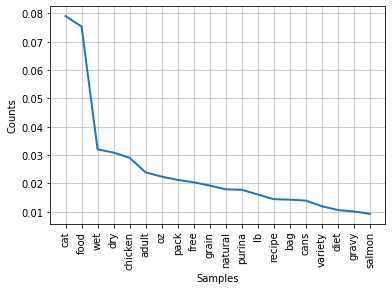

---------- Top 10 Bigram ------------
[(('cat', 'food'), 0.07020746887966806),
 (('wet', 'cat'), 0.028713692946058092),
 (('dry', 'cat'), 0.028049792531120332),
 (('grain', 'free'), 0.018921161825726143),
 (('oz', 'cans'), 0.012116182572614109),
 (('lb', 'bag'), 0.010622406639004149),
 (('variety', 'pack'), 0.008962655601659751),
 (('blue', 'buffalo'), 0.007800829875518672),
 (('high', 'protein'), 0.007302904564315353),
 (('food', 'chicken'), 0.006970954356846473)]


In [73]:
# cat
cat_filtered_token_list = filter_by_stop_words(tokenize_dataframe(cat_rdy_df, 'product'))
cat_top_10_most_common_word_in_product = freq_distribution_analysis(cat_filtered_token_list)
bigram_analysis(cat_filtered_token_list)

Length of tokens: 8602
Length of unique tokens: 791
---------- Top 20 Tokens ------------
['dog',
 'food',
 'dry',
 'adult',
 'chicken',
 'lb',
 'natural',
 'recipe',
 'bag',
 'free',
 'wet',
 'grain',
 'diet',
 'rice',
 'protein',
 'breed',
 'small',
 'pack',
 'oz',
 'high']


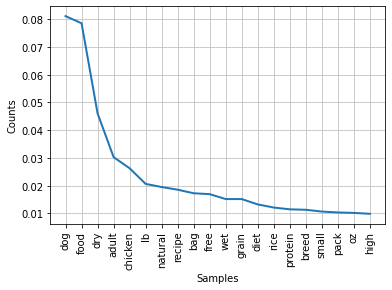

---------- Top 10 Bigram ------------
[(('dog', 'food'), 0.07392494765662748),
 (('dry', 'dog'), 0.044290545981639555),
 (('grain', 'free'), 0.01449508777580931),
 (('lb', 'bag'), 0.013528748590755355),
 (('wet', 'dog'), 0.013206635529070703),
 (('adult', 'dry'), 0.011596070220647446),
 (('high', 'protein'), 0.008697052665485585),
 (('food', 'chicken'), 0.007891770011273957),
 (("hill's", 'science'), 0.006120148172008375),
 (('science', 'diet'), 0.006120148172008375)]


In [74]:
# dog
dog_filtered_token_list = filter_by_stop_words(tokenize_dataframe(dog_rdy_df, 'product'))
dog_top_10_most_common_word_in_product = freq_distribution_analysis(dog_filtered_token_list)
bigram_analysis(dog_filtered_token_list)

Length of tokens: 5430
Length of unique tokens: 772
---------- Top 20 Tokens ------------
['food',
 'bird',
 'lb',
 'birds',
 'pound',
 'wild',
 'kaytee',
 'pet',
 'blend',
 'parrot',
 'daily',
 'bag',
 'pack',
 'seed',
 'natural',
 'lbs',
 'small',
 'higgins',
 'mix',
 'non-gmo']


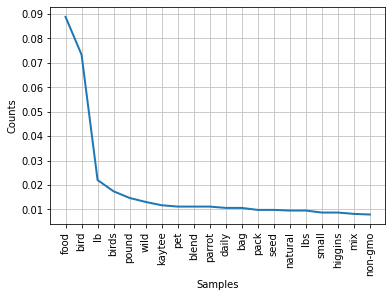

In [75]:
# bird
bird_filtered_token_list = filter_by_stop_words(tokenize_dataframe(bird_rdy_df, 'product'))
bird_top_10_most_common_word_in_product = freq_distribution_analysis(bird_filtered_token_list)

Length of tokens: 4348
Length of unique tokens: 840
---------- Top 20 Tokens ------------
['fish',
 'food',
 'tropical',
 'oz',
 'pellets',
 'foods',
 'koi',
 'natural',
 'aquatic',
 'lb',
 'flakes',
 'dog',
 'formula',
 'protein',
 'color',
 'premium',
 'floating',
 'goldfish',
 'dried',
 'shrimp']


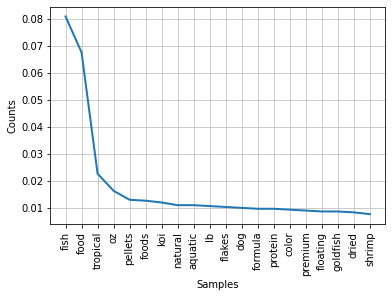

In [76]:
# fish
fish_filtered_token_list = filter_by_stop_words(tokenize_dataframe(fish_rdy_df, 'product'))
fish_top_10_most_common_word_in_product = freq_distribution_analysis(fish_filtered_token_list)

#5. Occurence of each brand


---
looking for the brand name in each product name, and rate the brand by rating and rating count
---



In [77]:
# the following are the brands getting from Amazon filter
# manually extract the most common brands for each search

# i am assuming the first word in each product as the brand name, for most of the cases, it works
# this is not accurate, deprecated
# def generate_brands_list(df):
#   product_list = df['product'].tolist()
#   return list(set([product.split()[0] for product in product_list]))

cat_brands_list = ['Purina', 'TIKI', 'ZIWI', 'Fussie', 'Caru', 'Whiskas', 'Friskies', 'Halo', 'Fromm', 'Hill\'s', 'Wellness', 'Natural Balance', 'Blue Buffalo', 'IAMS', 'SHEBA', 'Rachael Ray', 'ORIJEN', 'Meow Mix', 'Royal Canin', 'Acana']
dog_brands_list = ['Purina', 'ZIWI', 'Cesar', 'Halo', 'Annamaet', 'Fromm', 'Hill\'s', 'Natural Balance', 'Raw Paws', 'Fruitables', 'Pedigree', 'V-dog', 'Blue Buffalo', 'ORIJEN', 'IAMS', 'Merrick', 'Taste of the Wild', 'Royal Canin', 'Rachael Ray', 'Nature\'s Recipe', 'DIAMOND NATURALS', 'Kibbles', 'VICTOR', 'Acana']
bird_brands_list = ['Nemeth', 'Harrison', 'Volkman', 'Pretty Bird', 'Cole\'s', 'Sun Seed', 'Zoo Med', 'Mazuri', 'LAFEBER\'S', 'Vitakraft', 'Wagner\'s', 'Pine Tree Farms', 'Wild Harvest', 'Kaytee', 'Wild Delight', 'Hagen', 'Volkman', 'ZuPreem', 'Lyric']
fish_brands_list = ['Sera', 'San Francisco Bay', 'Piscine Energetics', 'GloFish', 'Amzey', 'Tetra Pond', 'Aqua Master', 'Zoo Med', 'Northfin', 'Mazuri', 'Omega One', 'Aquatic Foods', 'BLUE RIDGE', 'Kaytee', 'Aqueon', 'LuckyQworms', 'Sakura', 'Kikari', 'API', 'Carnivorous', 'Gargeer', 'Fluval']
# cat_brands_list = generate_brands_list(cat_rdy_df)
# dog_brands_list = generate_brands_list(dog_rdy_df)
# bird_brands_list = generate_brands_list(bird_rdy_df)
# fish_brands_list = generate_brands_list(fish_rdy_df)


In [78]:
# reframe the dataframe for each category, add a new column called brand by searching through product to find substring if exists in the relative brands list

#  helper function to determine the brand for each product
def check_brand(row, brands_list):  
  for brand in brands_list:
    # compare in lowercase
    if brand in row['product']:
      return brand
  return 'Others'
      


In [79]:
import numpy as np
# cat
cat_brand_df = cat_rdy_df.copy()
cat_brand_df['brand'] = cat_brand_df.apply(lambda row: check_brand(row, cat_brands_list), axis=1)

In [80]:
# dog
dog_brand_df = dog_rdy_df.copy()
dog_brand_df['brand'] = dog_brand_df.apply(lambda row: check_brand(row, dog_brands_list), axis=1)

In [81]:
# bird
bird_brand_df = bird_rdy_df.copy()
bird_brand_df['brand'] = bird_brand_df.apply(lambda row: check_brand(row, bird_brands_list), axis=1)

In [82]:
# fish
fish_brand_df = fish_rdy_df.copy()
fish_brand_df['brand'] = fish_brand_df.apply(lambda row: check_brand(row, fish_brands_list), axis=1)

In [83]:
# all
all_brand_df = all_rdy_df.copy()
all_brand_df['brand'] = all_brand_df.apply(lambda row: check_brand(row, [*cat_brands_list, *dog_brands_list, *bird_brands_list, *fish_brands_list]), axis=1)

##5.1 Describe the average value of each parameters for each brand in each category


In [84]:
# i am going to use it to do the pie chart
import plotly.express as px

In [85]:
# helper function to group dataframe by brand, and average the following parameters
def perform_mean_by_brand(df):
  new_df = df.copy()
  new_df_sum = new_df.groupby('brand', as_index=False)['rating_count'].apply(np.sum).rename(columns={'rating_count':'total_rating_count'})
  new_df_mean = new_df.groupby('brand', as_index=False)[['rating', 'rating_count', 'price', 'unit_price']].apply(np.mean).rename(columns={'rating':'mean_rating', 'rating_count':'mean_rating_count', 'price': 'mean_price', 'unit_price': 'mean_unit_price'})
  new_df_size = new_df.groupby('brand', as_index=False).size().rename(columns={'size':'occurrence'})
  new_df_merge = pd.merge(pd.merge(new_df_mean, new_df_size, on='brand'), new_df_sum, on='brand').sort_values(by='total_rating_count', ascending=False).reset_index(drop=True)

  return new_df_merge

# helper function to pie chart the dataframe by 
def pie_chart_market_share(df, values, names, title):
  fig = px.pie(df, values=values, names=names, title=title)
  fig.show()

In [86]:
# cat
cat_brand_mean_df = perform_mean_by_brand(cat_brand_df)
cat_brand_mean_df.to_csv('cat_food_market_popularity.csv', index=False)
display(cat_brand_mean_df)


,brand,mean_rating,mean_rating_count,mean_price,mean_unit_price,occurrence,total_rating_count
0,Purina,4.629907,6383.177570,24.610561,4.816542,107,683000
1,Others,4.443046,3205.251656,26.571126,7.025232,151,483993
2,Blue Buffalo,4.519149,2601.914894,30.985106,4.625957,47,122290
3,Hill's,4.652381,2883.047619,39.414048,4.145714,42,121088
4,IAMS,4.727273,7780.818182,23.129091,3.209091,11,85589
5,Meow Mix,4.655556,7091.222222,13.901111,2.458889,9,63821
6,Rachael Ray,4.457143,6272.428571,17.462857,5.438571,7,43907
7,Friskies,4.700000,14778.500000,9.885000,6.860000,2,29557
8,Royal Canin,4.707692,1865.000000,40.752308,7.534615,13,24245
9,Wellness,4.440000,919.080000,32.518000,6.198000,25,22977


In [87]:
# do the plot
pie_chart_market_share(df=cat_brand_mean_df, values='occurrence', names='brand', title='Cat Food Brand Market Occurrence According to Amazon Research Result')


In [88]:
# dog
dog_brand_mean_df = perform_mean_by_brand(dog_brand_df)
dog_brand_mean_df.to_csv('dog_food_market_popularity.csv', index=False)
display(dog_brand_mean_df)

,brand,mean_rating,mean_rating_count,mean_price,mean_unit_price,occurrence,total_rating_count
0,Others,4.474020,2911.627451,43.046127,5.787990,204,593972
1,Purina,4.652174,6273.413043,32.931522,4.027826,46,288577
2,Hill's,4.698113,3484.264151,55.960189,5.569245,53,184666
3,Blue Buffalo,4.644444,5993.148148,33.721852,3.559630,27,161815
4,IAMS,4.720000,6055.200000,31.024000,4.867000,10,60552
5,Rachael Ray,4.600000,5605.750000,27.725000,2.158750,8,44846
6,Royal Canin,4.764286,3197.214286,59.196429,3.985000,14,44761
7,Taste of the Wild,4.700000,7756.000000,50.240000,2.112500,4,31024
8,Nature's Recipe,4.628571,4372.428571,18.018571,3.741429,7,30607
9,Pedigree,4.700000,7374.750000,19.332500,8.817500,4,29499


In [89]:
# do the plot
pie_chart_market_share(df=dog_brand_mean_df, values='occurrence', names='brand', title='Dog Food Brand Market Occurrence According to Amazon Research Result')

In [90]:
# bird
bird_brand_mean_df = perform_mean_by_brand(bird_brand_df)
bird_brand_mean_df.to_csv('bird_food_market_popularity.csv', index=False)
display(bird_brand_mean_df)

,brand,mean_rating,mean_rating_count,mean_price,mean_unit_price,occurrence,total_rating_count
0,Others,4.510582,587.428571,28.253810,5.640529,189,111024
1,Kaytee,4.425581,2517.744186,17.219302,4.127674,43,108263
2,ZuPreem,4.655556,1015.000000,22.517778,4.199444,18,18270
3,Lyric,4.560000,3240.800000,30.704000,-17.800000,5,16204
4,Wild Harvest,4.520000,3204.600000,8.018000,1.936000,5,16023
5,Harrison,4.657143,631.952381,46.676190,6.409524,21,13271
6,Hagen,4.500000,739.250000,26.803750,10.056250,8,5914
7,Volkman,4.572727,373.545455,32.236364,6.811818,11,4109
8,Vitakraft,4.550000,858.750000,10.290000,4.077500,4,3435
9,Pretty Bird,4.647059,130.647059,29.664706,4.169412,17,2221


In [91]:
# do the plot
pie_chart_market_share(df=bird_brand_mean_df, values='occurrence', names='brand', title='Bird Food Brand Market Occurrence According to Amazon Research Result')

In [92]:
# fish
fish_brand_mean_df = perform_mean_by_brand(fish_brand_df)
fish_brand_mean_df.to_csv('fish_food_market_popularity.csv', index=False)
display(fish_brand_mean_df)

,brand,mean_rating,mean_rating_count,mean_price,mean_unit_price,occurrence,total_rating_count
0,Others,4.530968,2321.154839,28.813226,12.174839,155,359779
1,Aqueon,4.516667,1280.333333,8.248333,2.665000,6,7682
2,Fluval,4.680000,1348.600000,12.144000,2.026000,5,6743
3,Omega One,4.500000,1694.000000,25.990000,0.500000,2,3388
4,Zoo Med,4.625000,389.750000,23.837500,2.507500,4,1559
5,Aquatic Foods,4.466667,39.285714,29.628095,5.419524,21,825
6,API,4.750000,358.000000,26.180000,-9.000000,2,716
7,Piscine Energetics,4.700000,296.000000,13.380000,0.000000,1,296
8,Northfin,4.600000,260.000000,24.650000,0.000000,1,260
9,Amzey,4.400000,202.000000,11.950000,11.950000,1,202


In [93]:
# do the plot
pie_chart_market_share(df=fish_brand_mean_df, values='occurrence', names='brand', title='Fish Food Brand Market Occurrence According to Amazon Research Result')

In [94]:
# all
all_brand_mean_df = perform_mean_by_brand(all_brand_df)
display(all_brand_mean_df)

,brand,mean_rating,mean_rating_count,mean_price,mean_unit_price,occurrence,total_rating_count
0,Others,4.481388,1996.444795,31.260252,7.500915,634,1265746
1,Purina,4.625926,6262.524691,28.323333,5.051049,162,1014529
2,Blue Buffalo,4.562025,4324.569620,32.318101,4.133291,79,341641
3,Hill's,4.676289,3193.175258,48.987526,5.857423,97,309738
4,IAMS,4.727273,7074.318182,26.381818,3.919091,22,155635
5,Kaytee,4.425581,2517.744186,17.219302,4.127674,43,108263
6,Rachael Ray,4.520000,6431.200000,23.378667,4.018000,15,96468
7,SHEBA,4.700000,20253.750000,21.770000,5.580000,4,81015
8,Royal Canin,4.737037,2555.777778,50.315926,5.694074,27,69006
9,Meow Mix,4.655556,7091.222222,13.901111,2.458889,9,63821


#6. User Review Analysis


---
I will pick the product with the highest rating count in Section.5
In this way, the product reveiw is more representative for each category
---



In [95]:
# find the product that has the highest rating_count of the brand that has the highest total_rating_count for each category
# and get teh product_url
def get_target_product_url(df, brand_df, category):
  # remove the OTHERS from the brand dataframe
  new_brand_df = brand_df.copy()
  new_brand_df.drop(new_brand_df[new_brand_df['brand'] == 'Others'].index, inplace=True)
  new_brand_df.reset_index(drop=True, inplace=True)
  display(new_brand_df)

  # get the top brand
  brand = new_brand_df.at[0,'brand']
  
  # search in the product dataframe, find the results belongs to the brand and get the url for the one with the highest rating count
  new_df = df.copy()
  new_df = new_df.loc[new_df['product'].str.contains(brand)].sort_values(by='rating_count', ascending=False)
  new_df.reset_index(drop=True, inplace=True)
  
  product_url = new_df.at[0, 'product_url']
  print(f'The chosen brand for {category} is {brand}, with the product {product_url}')
  return product_url
  

In [96]:
# cat
cat_url = get_target_product_url(cat_rdy_df, cat_brand_mean_df, 'Cat Food')

,brand,mean_rating,mean_rating_count,mean_price,mean_unit_price,occurrence,total_rating_count
0,Purina,4.629907,6383.177570,24.610561,4.816542,107,683000
1,Blue Buffalo,4.519149,2601.914894,30.985106,4.625957,47,122290
2,Hill's,4.652381,2883.047619,39.414048,4.145714,42,121088
3,IAMS,4.727273,7780.818182,23.129091,3.209091,11,85589
4,Meow Mix,4.655556,7091.222222,13.901111,2.458889,9,63821
5,Rachael Ray,4.457143,6272.428571,17.462857,5.438571,7,43907
6,Friskies,4.700000,14778.500000,9.885000,6.860000,2,29557
7,Royal Canin,4.707692,1865.000000,40.752308,7.534615,13,24245
8,Wellness,4.440000,919.080000,32.518000,6.198000,25,22977
9,ORIJEN,4.625000,2680.000000,54.735000,6.892500,4,10720


The chosen brand for Cat Food is Purina, with the product https://amazon.com/Purina-Friskies-Seafood-Chicken-Variety/dp/B0777NRJ2N/ref=sr_1_16?keywords=cat+food&qid=1651895503&s=pet-supplies&sprefix=cat+food%2Cpets%2C84&sr=1-16


In [97]:
# dog
dog_url = get_target_product_url(dog_rdy_df, dog_brand_mean_df, 'Dog Food')

,brand,mean_rating,mean_rating_count,mean_price,mean_unit_price,occurrence,total_rating_count
0,Purina,4.652174,6273.413043,32.931522,4.027826,46,288577
1,Hill's,4.698113,3484.264151,55.960189,5.569245,53,184666
2,Blue Buffalo,4.644444,5993.148148,33.721852,3.559630,27,161815
3,IAMS,4.720000,6055.200000,31.024000,4.867000,10,60552
4,Rachael Ray,4.600000,5605.750000,27.725000,2.158750,8,44846
5,Royal Canin,4.764286,3197.214286,59.196429,3.985000,14,44761
6,Taste of the Wild,4.700000,7756.000000,50.240000,2.112500,4,31024
7,Nature's Recipe,4.628571,4372.428571,18.018571,3.741429,7,30607
8,Pedigree,4.700000,7374.750000,19.332500,8.817500,4,29499
9,Natural Balance,4.620000,1970.200000,46.754000,2.793000,10,19702


The chosen brand for Dog Food is Purina, with the product https://amazon.com/Purina-Smartblend-Instinct-Tender-Chicken/dp/B01EYB3K1Q/ref=sr_1_121?keywords=dog+food&qid=1651895782&s=pet-supplies&sprefix=dog+food%2Cpets%2C84&sr=1-121


In [98]:
# cat
bird_url = get_target_product_url(bird_rdy_df, bird_brand_mean_df, 'Bird Food')

,brand,mean_rating,mean_rating_count,mean_price,mean_unit_price,occurrence,total_rating_count
0,Kaytee,4.425581,2517.744186,17.219302,4.127674,43,108263
1,ZuPreem,4.655556,1015.000000,22.517778,4.199444,18,18270
2,Lyric,4.560000,3240.800000,30.704000,-17.800000,5,16204
3,Wild Harvest,4.520000,3204.600000,8.018000,1.936000,5,16023
4,Harrison,4.657143,631.952381,46.676190,6.409524,21,13271
5,Hagen,4.500000,739.250000,26.803750,10.056250,8,5914
6,Volkman,4.572727,373.545455,32.236364,6.811818,11,4109
7,Vitakraft,4.550000,858.750000,10.290000,4.077500,4,3435
8,Pretty Bird,4.647059,130.647059,29.664706,4.169412,17,2221
9,Nemeth,4.500000,1539.000000,67.880000,0.850000,1,1539


The chosen brand for Bird Food is Kaytee, with the product https://amazon.com/Kaytee-Spray-Millet-12-Count-Packaging/dp/B000VOE3QW/ref=sr_1_91?keywords=bird+food&qid=1651895930&s=pet-supplies&sprefix=bird+food%2Cpets%2C84&sr=1-91


In [99]:
# cat
fish_url = get_target_product_url(fish_rdy_df, fish_brand_mean_df, 'Fish Food')

,brand,mean_rating,mean_rating_count,mean_price,mean_unit_price,occurrence,total_rating_count
0,Aqueon,4.516667,1280.333333,8.248333,2.665000,6,7682
1,Fluval,4.680000,1348.600000,12.144000,2.026000,5,6743
2,Omega One,4.500000,1694.000000,25.990000,0.500000,2,3388
3,Zoo Med,4.625000,389.750000,23.837500,2.507500,4,1559
4,Aquatic Foods,4.466667,39.285714,29.628095,5.419524,21,825
5,API,4.750000,358.000000,26.180000,-9.000000,2,716
6,Piscine Energetics,4.700000,296.000000,13.380000,0.000000,1,296
7,Northfin,4.600000,260.000000,24.650000,0.000000,1,260
8,Amzey,4.400000,202.000000,11.950000,11.950000,1,202
9,GloFish,4.600000,195.000000,9.000000,5.660000,1,195


The chosen brand for Fish Food is Aqueon, with the product https://amazon.com/Aqueon-06188-Shrimp-Pellets-4-Ounce/dp/B004GWQ2TQ/ref=sr_1_33?keywords=fish+food&qid=1651896442&s=pet-supplies&sprefix=fish+food%2Cpets%2C84&sr=1-33


In [100]:
# write the url into a txt file, which will be used in the next step
lines = [cat_url, dog_url, bird_url, fish_url]
with open('product_urls.txt', 'w') as f:
    f.write('\n'.join(lines))

In [101]:
# then run locally, using the program
# https://github.com/scrapehero-code/amazon-review-scraper based on Selectorlib
# i ran the first 10 pages for each product on the customer review, sort by the most recent
# i made some modification to it so that it can fetch from Amazon without throwing any error
# the modified code is attached in the folder(review_dataset) for submission {cat.csv, dog.csv, bird.csv, fish.csv} with corresponding searching url
# also, it contains the urls and csv file generated through the scrapper

## 6.1 Prepare the review dataset



---
Read the csv into pandas dataframe
---



In [102]:
# read csv into dataframe
review_base_path = '/content/drive/MyDrive/IST 652 Lab/Final Project/review_dataset/'

# cat
cat_review_df = pd.read_csv('{0}cat.csv'.format(review_base_path), encoding = 'utf-8', on_bad_lines='skip')
cat_review_df.fillna('N/A', inplace=True)

# dog
dog_review_df = pd.read_csv('{0}dog.csv'.format(review_base_path), encoding = 'utf-8', on_bad_lines='skip')
dog_review_df.fillna('N/A', inplace=True)

# bird
bird_review_df = pd.read_csv('{0}bird.csv'.format(review_base_path), encoding = 'utf-8', on_bad_lines='skip')
bird_review_df.fillna('N/A', inplace=True)

# fish
fish_review_df = pd.read_csv('{0}fish.csv'.format(review_base_path), encoding = 'utf-8', on_bad_lines='skip')
fish_review_df.fillna('N/A', inplace=True)

# all
all_review_df = pd.concat([cat_review_df, dog_review_df, bird_review_df, fish_review_df], ignore_index=True)

display(all_review_df.head(5))

,title,content,date,variant,images,verified,author,rating,product,url
0,Fav of picky kitty,Our kitty only likes gravy style. It’s hard t...,05 May 2022,Size: 3 Ounce (Pack of 24) Color: Poultry & Be...,N/A,Yes,Sherri 456,5.0,Purina Fancy Feast Gravy Wet Cat Food Variety ...,https://www.amazon.com/product-reviews/B00JN9I...
1,Cat loves it,My cat won't eat any other canned food. She r...,04 May 2022,Size: 3 Ounce (Pack of 24) Color: Poultry & Be...,N/A,Yes,Robin Q,5.0,Purina Fancy Feast Gravy Wet Cat Food Variety ...,https://www.amazon.com/product-reviews/B00JN9I...
2,that your cat likes it,cat likes seafood the best. he does eat the o...,04 May 2022,Size: 3 Ounce (Pack of 24) Color: Poultry & Be...,N/A,Yes,arlene,4.0,Purina Fancy Feast Gravy Wet Cat Food Variety ...,https://www.amazon.com/product-reviews/B00JN9I...
3,My Sadie Love it!,"Our kitty loves fancy feast. However, for wha...",04 May 2022,Size: 3 Ounce (Pack of 24) Color: Poultry & Be...,N/A,Yes,G. Sunderlin,5.0,Purina Fancy Feast Gravy Wet Cat Food Variety ...,https://www.amazon.com/product-reviews/B00JN9I...
4,My Kitties like it,My Kitties like Fancy Feast.,04 May 2022,Size: 3 Ounce (Pack of 24) Color: Poultry & Be...,N/A,Yes,Ronald S.,5.0,Purina Fancy Feast Gravy Wet Cat Food Variety ...,https://www.amazon.com/product-reviews/B00JN9I...


## 6.2 Tokenize the review content


---
We want to extract the keyword for the positive(4-5) and negative(1-2) and neutral(3) rating for each category, so that we could know the focus points for each level of rating, and we can compare the difference between each categories
---



In [103]:
# import neccessary package for this part
# import nltk to analysis string
# import nltk

# # downloads stopwords
# nltk.download('stopwords')

# from nltk.collocations import *

# import re

Length of tokens: 3158
Length of unique tokens: 787
---------- Top 20 Tokens ------------
['food',
 'cat',
 'cats',
 'gravy',
 'loves',
 'like',
 'eat',
 'fancy',
 'feast',
 'box',
 'love',
 'price',
 'great',
 'cans',
 'amazon',
 'get',
 'find',
 'little',
 'one',
 'wet']


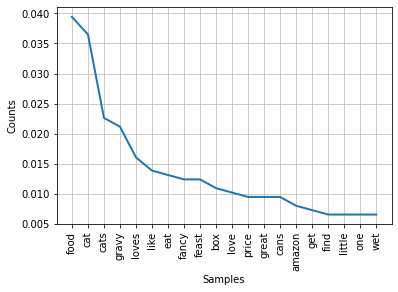

---------- Top 10 Bigram ------------
[(('2x', 'normal'), 0.001610305958132045),
 (('3rd', 'parties'), 0.001610305958132045),
 (('a-lot', 'fussy'), 0.001610305958132045),
 (('able', 'order'), 0.001610305958132045),
 (('absolutely', 'stray'), 0.001610305958132045),
 (('add', 'thin'), 0.001610305958132045),
 (('address', 'olaf'), 0.001610305958132045),
 (('ago', 'would'), 0.001610305958132045),
 (('alone', 'works'), 0.001610305958132045),
 (('along', 'cup'), 0.001610305958132045)]


In [104]:
# we can use the tokenizer we defined in Section.4
# cat
cat_review_all_filtered_token_list = filter_by_stop_words(tokenize_dataframe(cat_review_df, 'content'))
cat_review_all_top_10_most_common_word_in_content = freq_distribution_analysis(cat_review_all_filtered_token_list)
bigram_analysis(cat_review_all_top_10_most_common_word_in_content)

Length of tokens: 2177
Length of unique tokens: 243
---------- Top 20 Tokens ------------
['dog',
 'like',
 'dogs',
 'refused',
 'small',
 'bought',
 'case',
 'eat',
 'heat',
 'wave',
 'issues',
 'food',
 'cans',
 'flavors',
 'loves',
 'sensitive',
 'one',
 'buying',
 'chicken',
 'duck']


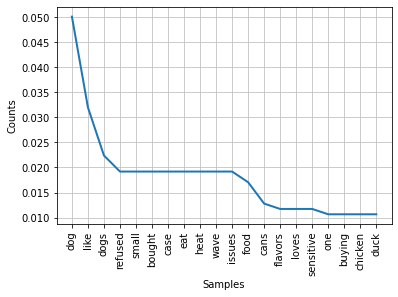

---------- Top 10 Bigram ------------
[(('dog', 'eat'), 0.019189765458422176),
 (('heat', 'wave'), 0.019189765458422176),
 (('chicken', 'duck'), 0.010660980810234541),
 (('turkey', 'venison'), 0.010660980810234541),
 (('agrees', 'dogs'), 0.009594882729211088),
 (('also', 'refused'), 0.009594882729211088),
 (('amount', 'local'), 0.009594882729211088),
 (('assume', 'exposed'), 0.009594882729211088),
 (('awful', 'dog'), 0.009594882729211088),
 (('beef', 'bison'), 0.009594882729211088)]


In [105]:
# dog
dog_review_all_filtered_token_list = filter_by_stop_words(tokenize_dataframe(dog_review_df, 'content'))
dog_review_all_top_most_common_word_in_content = freq_distribution_analysis(dog_review_all_filtered_token_list)
bigram_analysis(dog_review_all_filtered_token_list)

Length of tokens: 2395
Length of unique tokens: 264
---------- Top 20 Tokens ------------
['millet',
 'bird',
 'package',
 'loves',
 'birds',
 'love',
 'open',
 'seed',
 'el',
 'llegó',
 'las',
 'con',
 'treat',
 'sprays',
 'old',
 'like',
 'knows',
 'order',
 'one',
 'well']


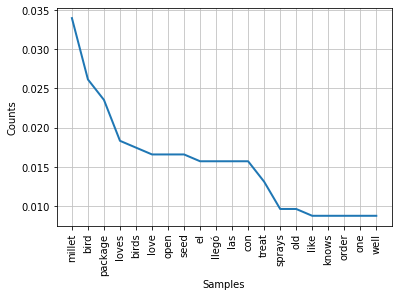

---------- Top 10 Bigram ------------
[(('bird', 'loves'), 0.016564952048823016),
 (('loves', 'treat'), 0.00959023539668701),
 (('love', 'millet'), 0.008718395815170008),
 (('millet', 'sprays'), 0.008718395815170008),
 (('abierto', 'descompuesto'), 0.007846556233653008),
 (('adios', 'birds'), 0.007846556233653008),
 (('april', 'subscribe'), 0.007846556233653008),
 (('bien', 'las'), 0.007846556233653008),
 (('bird', 'seed'), 0.007846556233653008),
 (('birds', 'love'), 0.007846556233653008)]


In [106]:
# bird
bird_review_all_filtered_token_list = filter_by_stop_words(tokenize_dataframe(bird_review_df, 'content'))
bird_review_all_top_most_common_word_in_content = freq_distribution_analysis(bird_review_all_filtered_token_list)
bigram_analysis(bird_review_all_filtered_token_list)

Length of tokens: 3324
Length of unique tokens: 272
---------- Top 20 Tokens ------------
['fish',
 'like',
 'bottom',
 'top',
 'food',
 'good',
 'sink',
 'pellets',
 'get',
 'love',
 'right',
 'around',
 'catfish',
 'loves',
 'seem',
 'excited',
 'mess',
 'open',
 'pretty',
 'quickly']


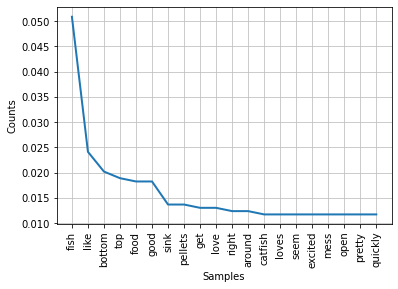

---------- Top 10 Bigram ------------
[(('fish', 'love'), 0.012393998695368558),
 (('fish', 'seem'), 0.011741682974559686),
 (('bottom', 'feeders'), 0.007175472928897586),
 (('fish', 'like'), 0.006523157208088715),
 (('sinking', 'pellets'), 0.006523157208088715),
 (('apart', 'super'), 0.005870841487279843),
 (('appreciate', 'food'), 0.005870841487279843),
 (('aquariums', 'full'), 0.005870841487279843),
 (('around', 'bad'), 0.005870841487279843),
 (('around', 'crushing'), 0.005870841487279843)]


In [107]:
# fish
fish_review_all_filtered_token_list = filter_by_stop_words(tokenize_dataframe(fish_review_df, 'content'))
fish_review_all_top_most_common_word_in_content = freq_distribution_analysis(fish_review_all_filtered_token_list)
bigram_analysis(fish_review_all_filtered_token_list)

Length of tokens: 11054
Length of unique tokens: 1095
---------- Top 20 Tokens ------------
['food',
 'like',
 'fish',
 'loves',
 'love',
 'cat',
 'eat',
 'dog',
 'cats',
 'open',
 'good',
 'millet',
 'one',
 'get',
 'top',
 'bottom',
 'product',
 'bird',
 'gravy',
 'small']


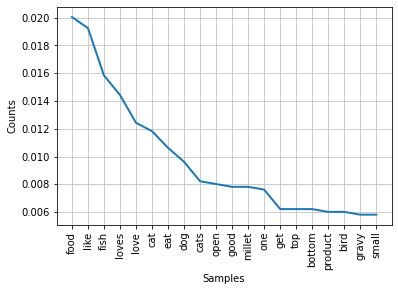

---------- Top 10 Bigram ------------
[(('bird', 'loves'), 0.003809141940657578),
 (('fish', 'love'), 0.003809141940657578),
 (('dog', 'eat'), 0.0036086607858861267),
 (('fish', 'seem'), 0.0036086607858861267),
 (('heat', 'wave'), 0.0036086607858861267),
 (('fancy', 'feast'), 0.003408179631114675),
 (('cat', 'food'), 0.0028067361668003207),
 (('bottom', 'feeders'), 0.0022052927024859663),
 (('cat', 'loves'), 0.0022052927024859663),
 (('loves', 'treat'), 0.0022052927024859663)]


In [108]:
# all
all_review_all_filtered_token_list = filter_by_stop_words(tokenize_dataframe(all_review_df, 'content'))
all_review_all_top_most_common_word_in_content = freq_distribution_analysis(all_review_all_filtered_token_list)
bigram_analysis(all_review_all_filtered_token_list)

## 6.2-1 Tokenize analysis on low rate reviews for all


---
This will tell me the characteristics of the review that for low rating
---



In [109]:
# filter the overall by rating
# convert the rating column into float
all_review_df['rating'] = all_review_df['rating'].apply(my_to_numeric).astype('float')

Length of tokens: 4245
Length of unique tokens: 496
---------- Top 20 Tokens ------------
['millet',
 'like',
 'package',
 'food',
 'one',
 'case',
 'heat',
 'open',
 'dog',
 'even',
 'bought',
 'seed',
 'refused',
 'small',
 'wave',
 'el',
 'llegó',
 'las',
 'con',
 'cats']


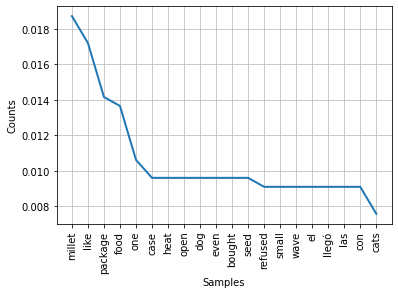

---------- Top 10 Bigram ------------
[(('heat', 'wave'), 0.009104704097116844),
 (('love', 'millet'), 0.005058168942842691),
 (('abierto', 'descompuesto'), 0.004552352048558422),
 (('adios', 'package'), 0.004552352048558422),
 (('also', 'refused'), 0.004552352048558422),
 (('amount', 'local'), 0.004552352048558422),
 (('assume', 'exposed'), 0.004552352048558422),
 (('awful', 'dog'), 0.004552352048558422),
 (('become', 'white'), 0.004552352048558422),
 (('beef', 'bison'), 0.004552352048558422)]


In [110]:
# filter by rating < 2
all_review_low_df = all_review_df.copy()
all_review_low_df = all_review_low_df.loc[all_review_low_df['rating'] < 3]
all_review_low_df.reset_index(drop=True, inplace=True)

# perform the analysis
all_review_low_filtered_token_list = filter_by_stop_words(tokenize_dataframe(all_review_low_df, 'content'))
all_review_low_top_most_common_word_in_content = freq_distribution_analysis(all_review_low_filtered_token_list)
bigram_analysis(all_review_low_filtered_token_list)

## 6.2-2 Tokenize analysis on neutral rate reviews for all


---
This will tell me the characteristics of the review that for neutral rating
---



Length of tokens: 429
Length of unique tokens: 184
---------- Top 20 Tokens ------------
['eat',
 'dog',
 'really',
 'hungry',
 'box',
 'missing',
 'cans',
 'cats',
 'delivery',
 'damage',
 'get',
 'flavor',
 'getting',
 'would',
 'chicken',
 'turkey',
 'price',
 'replacement',
 'need',
 'cat']


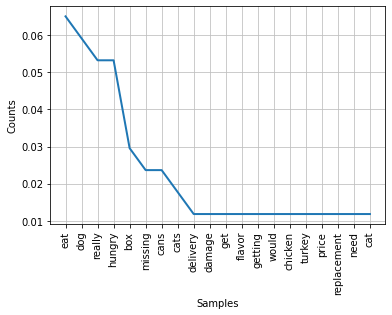

---------- Top 10 Bigram ------------
[(('dog', 'eat'), 0.05325443786982249),
 (('eat', 'really'), 0.05325443786982249),
 (('really', 'hungry'), 0.05325443786982249),
 (('hungry', 'dog'), 0.047337278106508875),
 (('box', 'damage'), 0.011834319526627219),
 (('cat', 'food'), 0.011834319526627219),
 (('2x', 'normal'), 0.005917159763313609),
 (('3rd', 'parties'), 0.005917159763313609),
 (('amz', '3rd'), 0.005917159763313609),
 (('anyone', 'would'), 0.005917159763313609)]


In [111]:
# filter by rating == 3
all_review_neutral_df = all_review_df.copy()
all_review_neutral_df = all_review_neutral_df.loc[all_review_neutral_df['rating'] == 3]
all_review_neutral_df.reset_index(drop=True, inplace=True)

# perform the analysis
all_review_neutral_filtered_token_list = filter_by_stop_words(tokenize_dataframe(all_review_neutral_df, 'content'))
all_review_neutral_top_most_common_word_in_content = freq_distribution_analysis(all_review_neutral_filtered_token_list)
bigram_analysis(all_review_neutral_filtered_token_list)

## 6.2-3 Tokenize analysis on high rate reviews for all


---
This will tell me the characteristics of the review that for high rating
---



Length of tokens: 6380
Length of unique tokens: 795
---------- Top 20 Tokens ------------
['food',
 'fish',
 'loves',
 'like',
 'love',
 'cat',
 'good',
 'eat',
 'bottom',
 'gravy',
 'right',
 'cats',
 'product',
 'open',
 'others',
 'around',
 'top',
 'bird',
 'dog',
 'issues']


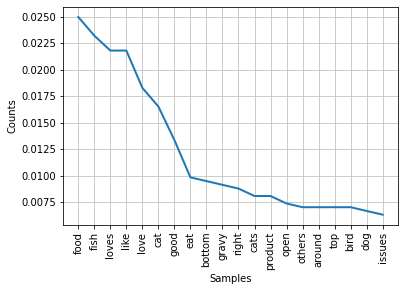

---------- Top 10 Bigram ------------
[(('bird', 'loves'), 0.006685432793807178),
 (('fish', 'love'), 0.006685432793807178),
 (('fancy', 'feast'), 0.0049261083743842365),
 (('cat', 'food'), 0.00422237860661506),
 (('cat', 'loves'), 0.0038705137227304713),
 (('loves', 'treat'), 0.0038705137227304713),
 (('like', 'comes'), 0.003518648838845883),
 (('like', 'variety'), 0.003518648838845883),
 (('subscribe', 'save'), 0.003518648838845883),
 (('agrees', 'dogs'), 0.0031667839549612948)]


In [112]:
# filter by rating > 3
all_review_high_df = all_review_df.copy()
all_review_high_df = all_review_high_df.loc[all_review_high_df['rating'] > 3]
all_review_high_df.reset_index(drop=True, inplace=True)

# perform the analysis
all_review_high_filtered_token_list = filter_by_stop_words(tokenize_dataframe(all_review_high_df, 'content'))
all_review_high_top_most_common_word_in_content = freq_distribution_analysis(all_review_high_filtered_token_list)
bigram_analysis(all_review_high_filtered_token_list)